In [31]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/char_transformer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/char_transformer'
/content/drive/.shortcut-targets-by-id/1ZdikWibndOy-EAHWOwKrJSalwWRmsckp/char_transformer


In [32]:
# Enable autoreload of local Python modules (e.g., models)
#%load_ext autoreload
#%autoreload 2

In [33]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax
import jax.numpy as jnp
import numpy as np
import optax
import time
from functools import partial
import matplotlib.pyplot as plt

# local imports
import models.swiglu as models
import util.generation as generation


In [34]:
# initialize the jax random key
key = jax.random.key(0)

# Load data

In [35]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [36]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [37]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [38]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

ombustion of fossilised forests coal oil and natural gas it seems clear that the use of forests to curb climate change can only 

o seven to five two micrometre wavelength ir light overlapping the wavelength range of ssi the telescope associated with nims is

 nine four five as the country s year of independence and expressed regrets over the indonesian deaths caused by the netherlands

orest people on the smallest farms in one eight four five for example two four of all irish tenant farms were of zero four to tw

roman empire and denmark from time to time taking part in the life of a divided poland to which it belonged from the point of vi



# Create a basic Transformer model

In [39]:
import jax.random as random
import jax


In [40]:
def create_train_state(rng=jax.random.key(0), vocab_size=27,
    d_model=256, n_layers=3, n_heads=8, max_len=128):
    # create a basic Transformer model
    base_model = models.DecoderOnlyTransformer(
      vocab_size=vocab_size,
      d_model=d_model,
      n_layers=n_layers,
      n_heads=n_heads,
      max_len=max_len,
      mlp_ratio=8/3,
      dropout_rate=0.00,
      tie_weights=True,
    )
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = base_model.init({"params": rng, "dropout": rng}, dummy, deterministic=True)["params"]
    return base_model, params

In [41]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))

In [42]:
model_1, params_1 = create_train_state()

print(f"base model param_count: {count_params(params_1):_}")

base model param_count: 2_405_884


In [43]:
# sanity check: create a batch of data & run a forward pass
'''
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)
'''

'\nB, T = 4, 32\nbatch = jax.random.randint(\n    key=key,\n    shape=(B, T), minval=0, maxval=len(char_set))\nlogits = model.apply({"params": params}, batch)\n\nprint("batch shape:", batch.shape)  # (B, T)\nprint("logits shape:", logits.shape)  # (B, T, vocab_size)\n'

# Loss function

In [44]:
# --- Loss and metrics (JIT-friendly) ---
import jax.nn as jnn
from functools import partial

@jax.jit
def loss_and_metrics(logits, targets):
    vocab_size = logits.shape[-1]
    logits_flat = logits.reshape(-1, vocab_size)
    targets_flat = targets.reshape(-1)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits_flat, targets_flat).mean()

    # compute token-level accuracy
    preds = jnp.argmax(logits, axis=-1)
    acc = (preds == targets).mean()

    # ✅ compute last character accuracy (final token per sequence) // NEW
    last_token_acc = (preds[:, -1] == targets[:, -1]).mean()

     # ✅ include it in the returned metrics
    return loss, {
        "loss": loss,
        "acc": acc,
        "acc_last": last_token_acc, # // NEW
    }

# Optimization step:

In [45]:
# create an update function
def train_step(params, opt_state, x, y, rng, tx, model):
    def loss_fn(params):
        logits = model.apply({"params": params}, x, deterministic=False)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx", "model"))


# Batch creation:

In [46]:
import jax
import jax.numpy as jnp

def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Optimizer creation:

In [65]:
# --- Optimizer and learning rate schedule ---
import optax

tx1 = lambda peak_lr, end_lr: optax.chain(
    optax.clip_by_global_norm(1.0),            # gradient clipping
    optax.adamw(
        learning_rate=optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=peak_lr,
            warmup_steps=5000,
            decay_steps=max(1, 100_000 - 5000),
            end_value=end_lr,
      ), weight_decay=0.01)
  )

In [62]:
def train(tx, B=256, T=32, niter=100_000, tl=5*60):
    model, params = create_train_state()
    print(f"No. of parameters: {count_params(params):_}")
    opt_state = tx.init(params)
    # produce a fresh subkey for randomness (dropout)
    rng, dropout_rng = jax.random.split(jax.random.key(0))
    loss_history = []
    time_history = []
    time_test_history = []
    loss_test_history = []
    time_start = time.time()
    it = 0
    while it < niter and time.time() - time_start < tl:
        batch = get_batch(train_text_int, B, T)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(
            params, opt_state, input, target, rng,
            tx=tx, model=model)

        # update params and opt_state
        params = params_new
        opt_state = opt_state_new
        acc = metrics['acc']
        acc_last = metrics['acc_last']
        loss = metrics['loss']

        loss_history.append(loss)
        time_history.append(time.time() - time_start)

        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on test set
            B_test, T_test = 1024, T
            test_batch = get_batch(test_text_int, B_test, T_test)
            test_input, test_target = test_batch[0], test_batch[1]
            test_logits = model.apply({"params": params}, test_input)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)
            test_acc = test_metrics['acc']
            test_acc_last = test_metrics['acc_last']
            loss_test_history.append(test_loss)
            time_test_history.append(time_since_start)
            if it % (niter // 5) == 0 or it == niter - 1:
              print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
              print(f"\t \t loss(train :: test): {loss:.4f} :: {test_loss:.4f}")
              print(f"\t \t accuracy (train :: test): {100*acc:.1f}% :: {100*test_acc:.1f}%")
              print(f"\t \t accuracy (last character) (train :: test): {100*acc_last:.1f}% :: {100*test_acc_last:.1f}%")
              print()
        it += 1
    print(it)
    return loss_history, time_history, loss_test_history, time_test_history, params



In [49]:
import csv

def csv_writing(lh, th, lth, tth, suffix):
    # Training metrics
    train_file_name = f"./data/changed_params/train_loss_{suffix}.csv"
    with open(train_file_name, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["time", "loss"])  # header
        writer.writerows(zip(th, lh))

    test_file_name = f"./data/changed_params/test_loss_{suffix}.csv"
    # Test metrics
    with open(test_file_name, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["time", "loss"])  # header
        writer.writerows(zip(tth, lth))

    print("csv files saved:", train_file_name, test_file_name)

In [58]:
peak, end = 1e-3, 2.5e-5
lh1, th1, lth1, tth1, params_1 = train(tx1(peak, end), tl=float('inf'))
csv_writing(lh1, th1, lth1, tth1, f"(Base + SwiGLU + WT + LPE)_LR(cosine decay)")

No. of parameters: 2_405_884
iteration 0  time: 10.8 seconds
	 	 loss(train :: test): 3.7701 :: 3.7884
	 	 accuracy (train :: test): 2.4% :: 2.6%
	 	 accuracy (last character) (train :: test): 2.0% :: 2.5%

iteration 20_000  time: 88.3 seconds
	 	 loss(train :: test): 1.2470 :: 1.3035
	 	 accuracy (train :: test): 60.3% :: 59.0%
	 	 accuracy (last character) (train :: test): 59.8% :: 61.8%

iteration 40_000  time: 165.8 seconds
	 	 loss(train :: test): 1.2031 :: 1.2646
	 	 accuracy (train :: test): 61.8% :: 60.4%
	 	 accuracy (last character) (train :: test): 67.6% :: 64.2%

iteration 60_000  time: 243.4 seconds
	 	 loss(train :: test): 1.2275 :: 1.2598
	 	 accuracy (train :: test): 61.2% :: 60.4%
	 	 accuracy (last character) (train :: test): 69.5% :: 62.2%

iteration 80_000  time: 321.1 seconds
	 	 loss(train :: test): 1.1866 :: 1.2351
	 	 accuracy (train :: test): 62.2% :: 61.1%
	 	 accuracy (last character) (train :: test): 71.1% :: 66.5%

iteration 99_999  time: 398.6 seconds
	 	 

No. of parameters: 2_405_884
iteration 0  time: 10.9 seconds
	 	 loss(train :: test): 3.7873 :: 3.7772
	 	 accuracy (train :: test): 2.6% :: 2.5%
	 	 accuracy (last character) (train :: test): 2.3% :: 2.4%

iteration 20_000  time: 88.4 seconds
	 	 loss(train :: test): 1.2912 :: 1.2985
	 	 accuracy (train :: test): 58.9% :: 59.3%
	 	 accuracy (last character) (train :: test): 62.1% :: 61.9%

iteration 40_000  time: 165.9 seconds
	 	 loss(train :: test): 1.2491 :: 1.2564
	 	 accuracy (train :: test): 60.5% :: 60.3%
	 	 accuracy (last character) (train :: test): 59.4% :: 64.6%

iteration 60_000  time: 243.4 seconds
	 	 loss(train :: test): 1.2258 :: 1.2462
	 	 accuracy (train :: test): 61.2% :: 60.9%
	 	 accuracy (last character) (train :: test): 60.9% :: 62.8%

iteration 80_000  time: 321.0 seconds
	 	 loss(train :: test): 1.1821 :: 1.2172
	 	 accuracy (train :: test): 63.1% :: 61.6%
	 	 accuracy (last character) (train :: test): 68.0% :: 65.7%

iteration 99_999  time: 398.5 seconds
	 	 

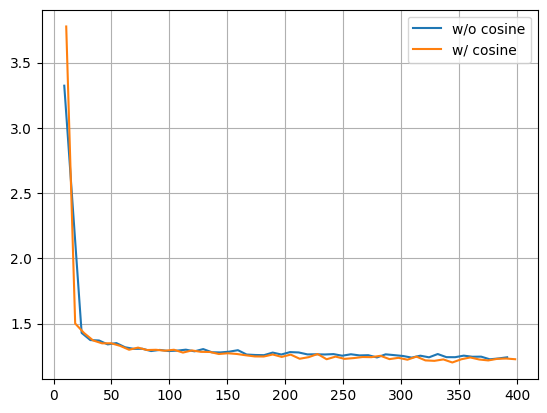

In [68]:
peak, end = 1e-3, 1e-5
lh2, th2, lth2, tth2, params_2 = train(tx1(peak, end), tl=float('inf'))
csv_writing(lh2, th2, lth2, tth2, f"(Base + SwiGLU + WT + LPE)_LR(cosine decay)_wd0.01")

dat1 = pd.read_csv('./data/base_swiglu_scale_wt_test_loss.csv')
plt.plot(dat1['loss'], dat1['time'], label="w/o cosine")
plt.plot(tth2, lth2, label="w/ cosine")
# plt.xlim(0, 300)
plt.grid()
plt.legend()

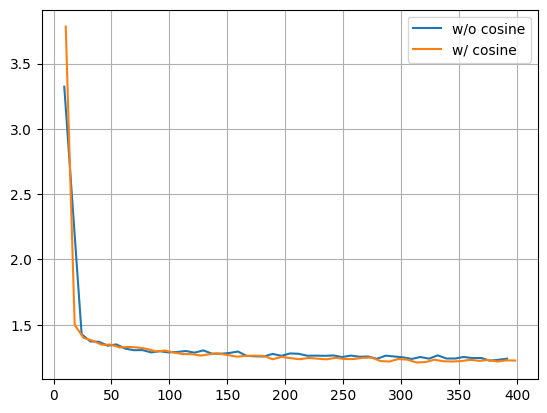

In [67]:
import pandas as pd

dat1 = pd.read_csv('./data/base_swiglu_scale_wt_test_loss.csv')
plt.plot(dat1['loss'], dat1['time'], label="w/o cosine")
plt.plot(tth2, lth2, label="w/ cosine")
# plt.xlim(0, 300)
plt.grid()
plt.legend()

In [ ]:
'''
adamw_lr = 1e-4
lh3, th3, lth3, tth3 = train(model_2, params_2, tx2(adamw_lr))
csv_writing(lh3, th3, lth3, tth3, f"Full (adamW)_LR({adamw_lr})")
'''

In [ ]:
'''
# plot the loss history
plt.figure(figsize=(12, 5))

# -------------------------
# Left plot: TRAINING LOSS
# -------------------------
plt.subplot(1, 2, 1)
plt.plot(th1, lh1, label=f"Base + Dropout + SwiGLU + weight tying, LR:{(peak, end)}")
plt.plot(th2, lh2, label=f"Full (cosine decay), LR:{(peak, end)}")
# plt.plot(th3, lh3, label=f"Full (adamW), LR:{adamw_lr}")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)

# -------------------------
# Right plot: TEST LOSS
# -------------------------
plt.subplot(1, 2, 2)
plt.plot(tth1, lth1, label="Base + Dropout + SwiGLU + weight tying")
plt.plot(tth2, lth2, label="Full (cosine decay)")
# plt.plot(tth3, lth3, label="Full (adamW)")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Test Loss History")
plt.legend()
plt.grid(True)

plt.suptitle(f"Optimizers: Cosine decay: {(peak, end)}")

plt.tight_layout()
plt.savefig('tff_1.png', bbox_inches='tight')
plt.show()


print("Full model has Xavier normal weight initialiser & explicit epsilon for LayerNorm")'''

In [ ]:
peak, end = 5e-4, 5e-5
lh4, th4, lth4, tth4, params_4 = train(decoder_4.DecoderOnlyTransformer, tx1(peak, end), label_smoothing=0)
csv_writing(lh4, th4, lth4, tth4, f"(Base + Dropout + SwiGLU + weight tying)_LR{(peak, end)}_no_smoothing")

In [ ]:
lh5, th5, lth5, tth5, params_5 = train(models_full.DecoderOnlyTransformer, tx1(peak, end),label_smoothing=0)
csv_writing(lh5, th5, lth5, tth5, f"Full (cosine decay)_LR{(peak, end)}_no_smoothing")

In [ ]:
'''adamw_lr = 1e-4
lh6, th6, lth6, tth6 = train(model_2, params_2, tx2(adamw_lr), label_smoothing=0)
csv_writing(lh6, th6, lth6, tth6, f"Full (adamW)_LR({adamw_lr})_no_smoothing")
'''

In [ ]:
# plot the loss history
plt.figure(figsize=(12, 5))

# -------------------------
# Left plot: TRAINING LOSS
# -------------------------
plt.subplot(1, 2, 1)
plt.plot(th1, lh1, label=f"Base + Dropout + SwiGLU + weight tying (with smoothing)")
plt.plot(th2, lh2, label=f"Full (cosine decay, with smoothing)")
plt.plot(th4, lh4, label=f"Base + Dropout + SwiGLU + weight tying (no smoothing)")
plt.plot(th5, lh5, label=f"Full (cosine decay, no smoothing)")
# plt.plot(th6, lh6, label=f"Full (adamW), LR:{adamw_lr}")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)

# -------------------------
# Right plot: TEST LOSS
# -------------------------
plt.subplot(1, 2, 2)
plt.plot(tth1, lth1, label="Base + Dropout + SwiGLU + weight tying (with smoothing)")
plt.plot(tth2, lth2, label="Full (cosine decay, with smoothing)")
plt.plot(tth4, lth4, label="Base + Dropout + SwiGLU + weight tying (no smoothing)")
plt.plot(tth5, lth5, label="Full (cosine decay, no smoothing)")
# plt.plot(tth6, lth6, label="Full (adamW)")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Test Loss History")
plt.legend()
plt.grid(True)

plt.suptitle(f"Optimizers: Cosine decay: {(peak, end)}, no smoothing")

plt.tight_layout()
plt.savefig('assets/tff_2.png', bbox_inches='tight')
plt.show()


print("Full model has Xavier normal weight initialiser & explicit epsilon for LayerNorm")

In [ ]:
# plot the loss history
plt.figure(figsize=(12, 5))

# -------------------------
# Left plot: TRAINING LOSS
# -------------------------
plt.subplot(1, 2, 1)
plt.plot(th4, lh4, label=f"Base + Dropout + SwiGLU + weight tying, LR:{(peak, end)}")
plt.plot(th5, lh5, label=f"Full (cosine decay), LR:{(peak, end)}")
# plt.plot(th6, lh6, label=f"Full (adamW), LR:{adamw_lr}")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)

# -------------------------
# Right plot: TEST LOSS
# -------------------------
plt.subplot(1, 2, 2)
plt.plot(tth4, lth4, label="Base + Dropout + SwiGLU + weight tying")
plt.plot(tth5, lth5, label="Full (cosine decay)")
# plt.plot(tth6, lth6, label="Full (adamW)")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Test Loss History")
plt.legend()
plt.grid(True)

plt.suptitle(f"Optimizers: Cosine decay: {(peak, end)}, no smoothing")

plt.tight_layout()
plt.savefig('assets/tff_2.png', bbox_inches='tight')
plt.show()


print("Full model has Xavier normal weight initialiser & explicit epsilon for LayerNorm")

In [ ]:
peak, end = 1e-4, 1e-5
lh7, th7, lth7, tth7 = train(model_1, params_1, tx1(peak, end))
csv_writing(lh7, th7, lth7, tth7, f"(Base + Dropout + SwiGLU + weight tying)_LR{(peak, end)}")

In [ ]:
lh8, th8, lth8, tth8 = train(model_2, params_2, tx1(peak, end))
csv_writing(lh8, th8, lth8, tth8, f"Full (cosine decay)_LR{(peak, end)}")

In [ ]:
'''
adamw_lr = 5e-5
lh9, th9, lth9, tth9 = train(model_2, params_2, tx2(adamw_lr))
csv_writing(lh9, th9, lth9, tth9, f"Full (adamW)_LR({adamw_lr})")
'''

In [ ]:
# plot the loss history
plt.figure(figsize=(12, 5))

# -------------------------
# Left plot: TRAINING LOSS
# -------------------------
plt.subplot(1, 2, 1)
plt.plot(th7, lh7, label=f"Base + Dropout + SwiGLU + weight tying, LR:{(peak, end)}")
plt.plot(th8, lh8, label=f"Full (cosine decay), LR:{(peak, end)}")
# plt.plot(th9, lh9, label=f"Full (adamW), LR:{adamw_lr}")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)

# -------------------------
# Right plot: TEST LOSS
# -------------------------
plt.subplot(1, 2, 2)
plt.plot(tth7, lth7, label="Base + Dropout + SwiGLU + weight tying")
plt.plot(tth8, lth8, label="Full (cosine decay)")
# plt.plot(tth9, lth9, label="Full (adamW)")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Test Loss History")
plt.legend()
plt.grid(True)

plt.suptitle(f"Optimizers: Cosine decay: {(peak, end)}")

plt.tight_layout()
plt.savefig('assets/tff_3.png', bbox_inches='tight')
plt.show()


print("Full model has Xavier normal weight initialiser & explicit epsilon for LayerNorm")

In [ ]:
peak, end = 1e-4, 1e-5
lh_a, th_a, lth_a, tth_a = train(model_1, params_1, tx1(peak, end), label_smoothing=0)
csv_writing(lh_a, th_a, lth_a, tth_a, f"(Base + Dropout + SwiGLU + weight tying)_LR{(peak, end)}_no_smoothing")

In [ ]:
lh_b, th_b, lth_b, tth_b = train(model_2, params_2, tx1(peak, end), label_smoothing=0)
csv_writing(lh_b, th_b, lth_b, tth_b, f"Full (cosine decay)_LR{(peak, end)}_no_smoothing")

In [ ]:
'''
adamw_lr = 5e-5
lh_c, th_c, lth_c, tth_c = train(model_2, params_2, tx2(adamw_lr), label_smoothing=0)
csv_writing(lh_c, th_c, lth_c, tth_c, f"Full (adamW)_LR({adamw_lr})_no_smoothing")
'''

In [ ]:
# plot the loss history
plt.figure(figsize=(12, 5))

# -------------------------
# Left plot: TRAINING LOSS
# -------------------------
plt.subplot(1, 2, 1)
plt.plot(th_a, lh_a, label=f"Base + Dropout + SwiGLU + weight tying, LR:{(peak, end)}")
plt.plot(th_b, lh_b, label=f"Full (cosine decay), LR:{(peak, end)}")
plt.plot(th_c, lh_c, label=f"Full (adamW), LR:{adamw_lr}")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.grid(True)

# -------------------------
# Right plot: TEST LOSS
# -------------------------
plt.subplot(1, 2, 2)
plt.plot(tth_a, lth_a, label="Base + Dropout + SwiGLU + weight tying")
plt.plot(tth_b, lth_b, label="Full (cosine decay)")
plt.plot(tth_c, lth_c, label="Full (adamW)")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Test Loss History")
plt.legend()
plt.grid(True)

plt.suptitle(f"Optimizers: Cosine decay: {(peak, end)}, adamW: {adamw_lr}, no smoothing")

plt.tight_layout()
plt.savefig('assets/tff_4.png', bbox_inches='tight')
plt.show()

print("Full model has Xavier normal weight initialiser & explicit epsilon for LayerNorm")
